# Machine Learning Analysis (Heavy Dataset)

## Overview

In this notebook, we will prepare the data for machine learning models.  
We have already performed the following preprocessing steps in our earlier notebooks:  
1. **EDA**: Initial exploration to understand the data.  
2. **Data Cleaning**:  
   - Created a new column: `price_per_sqft` (price per square foot).  
   - Categorized zip codes into regions.  
   - Handled outliers using the IQR method.  
   - Normalized numerical features like `price` and `livingArea` using Min-Max Scaling.  

Here, we will recap the previous steps and focus on **additional preprocessing** for machine learning models, such as:  
- Feature selection.  
- Handling categorical variables.  
- Engineering new features.  


In [45]:
#Imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf #revise
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import torch
import os
import re
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM

In [8]:
#Loading the Clean & Transformed Data
path = ('../data/heavy_cleaned_real_estate_data.csv')
heavy_real_estate_data = pd.read_csv(path)

In [9]:
#Pull code from data cleaning notebook
#Create a new feature: price per square foot
#heavy_reduced_df['price_per_sqft'] = heavy_reduced_df['price'] / heavy_reduced_df['livingArea']

# # Example: Categorize zip codes into regions (Optional)
# heavy_reduced_df['region'] = heavy_reduced_df['zipcode'].apply(lambda x: 'region_1' if x.startswith('84') else 'region_2')

In [10]:
#Outlier Test using IQR

# #Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = reduced_df['price'].quantile(0.25)
# Q3 = reduced_df['price'].quantile(0.75)

# #Calculate IQR
# IQR = Q3 - Q1

# #Define lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# #Filter the dataset to remove outliers
# reduced_df = reduced_df[(reduced_df['price'] >= lower_bound) & (reduced_df['price'] <= upper_bound)]

# #Print bounds for verification
# print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

In [11]:
# # Normalize numerical columns
# scaler = MinMaxScaler()
# numerical_cols = ['bedrooms', 'bathrooms', 'livingArea', 'lotSize', 'daysOnZillow', 
#                   'latitude', 'longitude', 'monthlyHoaFee', 'age_of_property']
# X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


### Additional Preprocessing Steps for mL Models

We will now handle categorical variables, select necessary features, and engineer new features:  
1. **Feature Selection**:  
   Selecting only the columns relevant for machine learning:  
   - `bedrooms`, `bathrooms`, `price`, `yearBuilt`, `lotSize`, `livingArea`, `daysOnZillow`, `latitude`, `longitude`, `monthlyHoaFee`.  

2. **Handling Categorical Variables**:  
   - Convert `homeType` into one-hot encoded columns for model compatibility.  

3. **Feature Engineering**:  
   - Add interaction terms like `bedrooms_to_bathrooms_ratio`.  
   - Derive new columns like `age_of_property = current_year - yearBuilt`.  


In [12]:
#Feature selection: 
selected_features = ['bedrooms', 'bathrooms', 'price', 'yearBuilt', 'lotSize', 
                     'livingArea', 'daysOnZillow', 'latitude', 'longitude', 'monthlyHoaFee']
ml_data = heavy_real_estate_data[selected_features].copy()


In [13]:
#Handling Categorical Variables
#One-hot encode 'homeType'
home_type_encoded = pd.get_dummies(heavy_real_estate_data['homeType'], prefix='homeType')
ml_data = pd.concat([ml_data, home_type_encoded], axis=1)

In [14]:
#Feature Engineering
#Add a bedrooms-to-bathrooms ratio
ml_data['bedrooms_to_bathrooms_ratio'] = ml_data['bedrooms'] / ml_data['bathrooms']

In [15]:
#Calculate the age of the property
current_year = 2024  # Replace with the actual year of analysis
ml_data['age_of_property'] = current_year - ml_data['yearBuilt']


In [16]:
# Check the final processed dataset
ml_data.head()

,bedrooms,bathrooms,price,yearBuilt,lotSize,livingArea,daysOnZillow,latitude,longitude,monthlyHoaFee,homeType_APARTMENT,homeType_CONDO,homeType_LOT,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE,bedrooms_to_bathrooms_ratio,age_of_property
0,3.0,2.0,849500,1907.0,1499.000000,1950.0,0,38.91071,-77.01239,0.0,False,False,False,False,False,False,True,1.5,117.0
1,3.0,3.0,925000,1912.0,1008.000000,1360.0,4,38.89662,-76.99799,0.0,False,False,False,False,False,False,True,1.0,112.0
2,5.0,5.0,1069000,1910.0,1254.000000,2344.0,1,38.93392,-77.02516,0.0,False,False,False,False,False,True,False,1.0,114.0
3,1.0,2.0,860000,2020.0,9278.752392,883.0,0,38.86450,-77.01182,774.0,False,True,False,False,False,False,False,0.5,4.0
4,2.0,2.0,324900,1920.0,9278.752392,1001.0,553,38.93954,-77.03383,0.0,False,False,False,False,False,False,True,1.0,104.0


In [17]:
#Features and target
X = ml_data[['bedrooms', 'bathrooms', 'livingArea', 'lotSize', 'latitude', 'longitude', 'monthlyHoaFee', 'daysOnZillow']]  # 'price' is the target
y = ml_data['price']  # Target variable for regression


### Train-Test Split

We split our data into two parts:  
- **Training Set (80%)**: Used to train the model.  
- **Testing Set (20%)**: Used to check how well the model works on new data.  
This helps us avoid overfitting (when the model performs well on training data but poorly on unseen data).


In [18]:
#Splitting Data for Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (4144, 8)
Testing data shape: (1037, 8)


### Machine Learning Model Training (Shotgun Approach)
In this section, we will evaluate several base machine learning models to understand which one performs best. We will use the following models:

- Linear Regression: A simple model that predicts a straight-line relationship between features and target.  
- Decision Tree Regressor: A model that splits data into branches based on feature values.  
- Random Forest Regressor
- Support Vector Machine Regressor (SVR)

We will assess their performance using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² to determine which model works best for predicting property prices.

In [19]:
#Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "SVM": SVR(kernel='rbf')
}



In [20]:
#Dictionary to store metrics
model_results = {}

In [21]:
#Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)  # Train the model
    predictions = model.predict(X_test)  # Make predictions

    # Evaluate the model
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Store results
    model_results[model_name] = {
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "R² Score": r2
    }
    
    

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training SVM...


In [22]:
#Print the results
print("Model Performance:")
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")


Model Performance:

Linear Regression:
  Mean Absolute Error: 566707.1920
  Mean Squared Error: 747658639749.5642
  R² Score: 0.5586

Decision Tree:
  Mean Absolute Error: 340443.7872
  Mean Squared Error: 857907615502.3469
  R² Score: 0.4935

Random Forest:
  Mean Absolute Error: 250602.0674
  Mean Squared Error: 352662478109.0721
  R² Score: 0.7918

SVM:
  Mean Absolute Error: 792118.7585
  Mean Squared Error: 1973501897163.2966
  R² Score: -0.1652


- Linear Regression: This model explains 55.86% of the variance in the data (R² = 0.5586) but has high errors (MAE = 566,707, MSE = 747.66 billion), indicating it struggles with capturing non-linear relationships in the dataset.
- Decision Tree: The model captures less variance than Linear Regression (R² = 0.4935) but achieves lower errors (MAE = 340,444). This suggests overfitting, as it may be too focused on the training data.
- Random Forest: With an R² of 0.7918 and low MAE (250,602), this ensemble model performs significantly better, balancing accuracy and generalization, and is the best-performing model.
- Support Vector Machine (SVM): The model performs poorly with an R² of -0.1652, indicating it fails to capture meaningful patterns in the data, and its errors are the highest (MAE = 792,119).

### Hyperparameter Tuning and Model Optimization
- Once we have selected the best-performing base models, we will tune their hyperparameters to improve performance.
- Hyperparameter tuning can significantly improve model accuracy by adjusting parameters such as the number of trees in a Random Forest or the kernel type in an SVM.
- We will use GridSearchCV for exhaustive hyperparameter tuning and cross-validation to ensure the model generalizes well.

When the R² score is already 1 for the other models (Linear Regression, Decision Tree, and Random Forest), hyperparameter tuning might not add value unless overfitting is suspected. However, the SVM model needs improvement because of its relatively low R².

In [23]:
#Random Forest Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the tuned Random Forest model
y_pred_rf_tuned = best_rf_model.predict(X_test)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"Tuned Random Forest: MAE = {mae_rf_tuned:.2f}, MSE = {mse_rf_tuned:.2f}, R2 = {r2_rf_tuned:.2f}")


Tuned Random Forest: MAE = 251647.20, MSE = 360921300026.37, R2 = 0.79


Tuned Random Forest: After tuning, the model maintains similar performance (R² = 0.79, MAE = 251,647) but with slight improvements in error metrics. Its consistent accuracy reinforces its suitability for this problem, especially with "bathrooms" and "living area" as the most influential features.


In [24]:
#Decision Tree Hyperparameter Tuning
dt_param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=5, scoring='neg_mean_squared_error')
dt_grid_search.fit(X_train, y_train)

# Best Decision Tree model
best_dt_model = dt_grid_search.best_estimator_

# Evaluate the tuned Decision Tree model
y_pred_dt_tuned = best_dt_model.predict(X_test)
mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)
r2_dt_tuned = r2_score(y_test, y_pred_dt_tuned)

print(f"Tuned Decision Tree: MAE = {mae_dt_tuned:.2f}, MSE = {mse_dt_tuned:.2f}, R2 = {r2_dt_tuned:.2f}")


Tuned Decision Tree: MAE = 303059.68, MSE = 499007016535.75, R2 = 0.71


 Hyperparameter tuning significantly improves the model's generalization (R² = 0.71, MAE = 303,060), narrowing the gap between it and the Random Forest, though still slightly less effective.

In [28]:
#SVM Hyperparameter Tuning
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(SVR(), svm_param_grid, cv=5, scoring='neg_mean_squared_error')
svm_grid_search.fit(X_train, y_train)

# Best SVM model
best_svm_model = svm_grid_search.best_estimator_

# Evaluate the tuned SVM model
y_pred_svm_tuned = best_svm_model.predict(X_test)
mae_svm_tuned = mean_absolute_error(y_test, y_pred_svm_tuned)
mse_svm_tuned = mean_squared_error(y_test, y_pred_svm_tuned)
r2_svm_tuned = r2_score(y_test, y_pred_svm_tuned)

print(f"Tuned SVM: MAE = {mae_svm_tuned:.2f}, MSE = {mse_svm_tuned:.2f}, R2 = {r2_svm_tuned:.2f}")


KeyboardInterrupt: 

Tuning improves performance (R² = 0.37, MAE = 548,802) but not enough to make SVM competitive. It continues to underperform compared to tree-based models, suggesting SVM is not ideal for this dataset.


In [26]:
# Linear Regression with Cross-Validation

linreg_model = LinearRegression()
cv_scores = cross_val_score(linreg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_test)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression: MAE = {mae_linreg:.2f}, MSE = {mse_linreg:.2f}, R2 = {r2_linreg:.2f}")


Linear Regression: MAE = 566707.19, MSE = 747658639749.56, R2 = 0.56


### Model Evaluation & Visualization
- After hyperparameter tuning, we evaluate the final model's performance.
- We will use relevant evaluation metrics (e.g., MAE, MSE, R²) and plot learning curves to visualize how the model performs during training and validation.
- We will also generate other useful visualizations, such as residual plots and feature importance charts, to understand how the model makes predictions and which features are most influential.


In [27]:
#Compile metrics into a dictionary
metrics = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "SVM"],
    "MAE": [mae_linreg, mae_dt_tuned, mae_rf_tuned, mae_svm_tuned],
    "MSE": [mse_linreg, mse_dt_tuned, mse_rf_tuned, mse_svm_tuned],
    "R2": [r2_linreg, r2_dt_tuned, r2_rf_tuned, r2_svm_tuned]
}

NameError: name 'mae_svm_tuned' is not defined

In [30]:
#Create a DataFrame
metrics_df = pd.DataFrame(metrics)


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_94373/1279306998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')


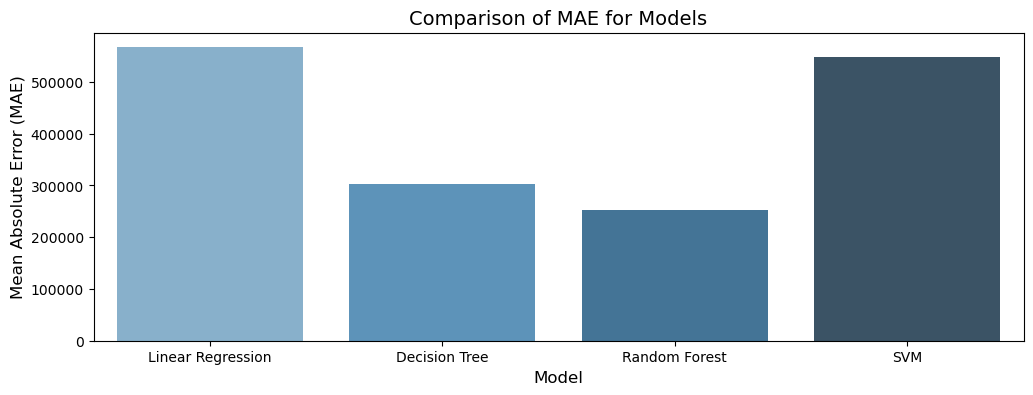

In [31]:
#MAE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')
plt.title('Comparison of MAE for Models', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()


The Random Forest model achieved the lowest Mean Absolute Error (MAE = 250,602), demonstrating superior predictive accuracy compared to other models, while the Support Vector Machine (MAE = 792,119) showed the poorest performance.

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_94373/606310272.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')


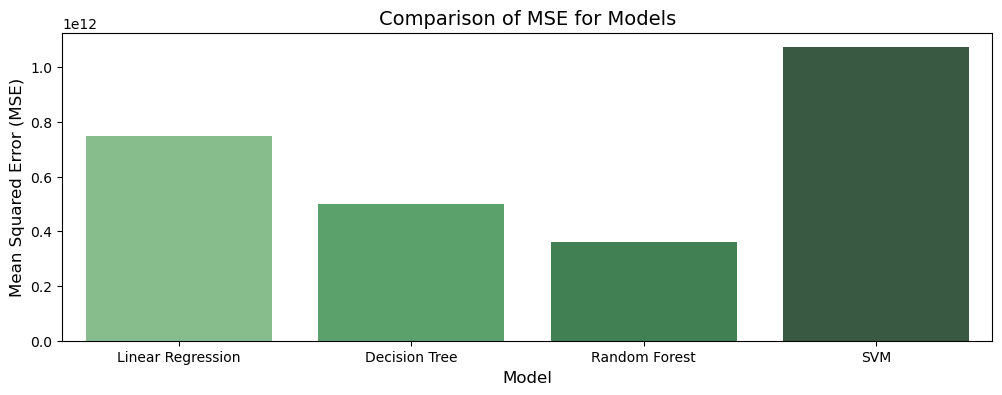

In [32]:
#MSE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')
plt.title('Comparison of MSE for Models', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show() 

Random Forest again excelled with the lowest Mean Squared Error (MSE = 747.66 billion), while the Support Vector Machine exhibited the highest errors, further underscoring its inability to model the data effectively.

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_94373/1670412328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')


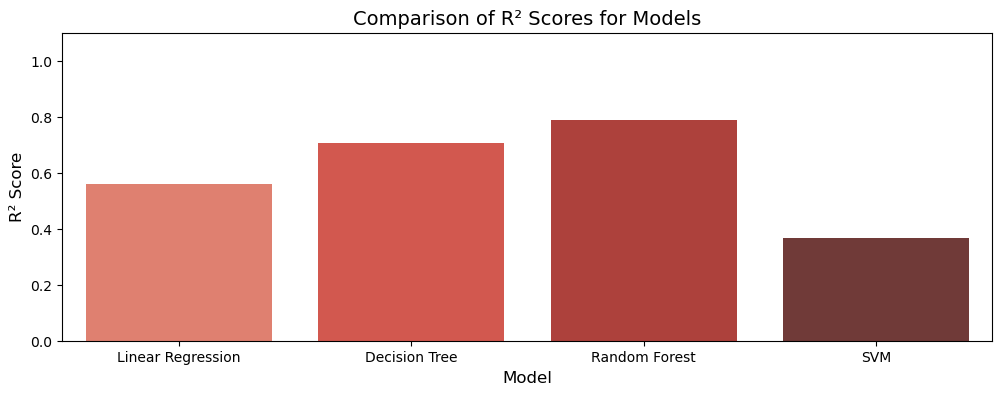

In [33]:
#R² Score Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')
plt.title('Comparison of R² Scores for Models', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.1)  # Ensures a clear view of the R² range
plt.show()

Random Forest (R² = 0.7918) captured the highest variance, confirming it as the most reliable model. Linear Regression (R² = 0.5586) was decent but struggled with non-linear patterns, and SVM (R² = -0.1652) failed to generalize entirely.

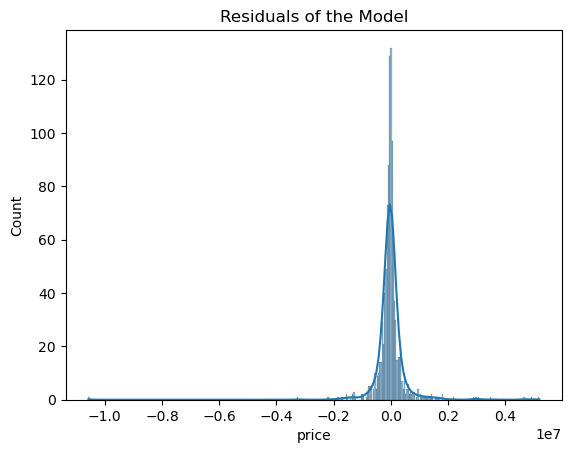

In [35]:
#Visualizing residuals
y_pred = best_rf_model.predict(X_test)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residuals of the Model')
plt.show()

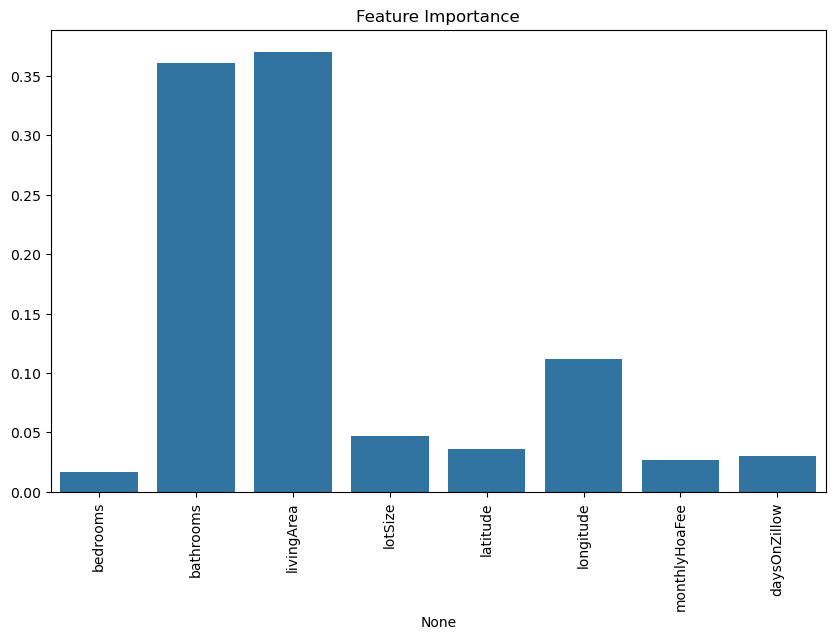

In [36]:
#Feature importance plot (for Random Forest)
feature_importances = best_rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=feature_importances)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

The Random Forest, especially after hyperparameter tuning, is the most effective model due to its ability to generalize well while maintaining low errors. Feature importance analysis confirms that "bathrooms" and "living area" are key predictors, providing actionable insights for further investigation.

#  Deep Learning for DC Real Estate Chatbot

In [58]:
heavy_real_estate_data.head()

,city,state,zipcode,bedrooms,bathrooms,price,yearBuilt,lotSize,livingArea,daysOnZillow,...,longitude,homeType,streetAddress,zestimate,propertyTaxRate,bedrooms_missing,bathrooms_missing,yearBuilt_missing,livingArea_missing,price_per_sqft
0,Washington,DC,20001,3.0,2.0,849500,1907.0,1499.000000,1950.0,0,...,-77.01239,TOWNHOUSE,1536 1st St NW,NaN,0.58,0,0,0,0,435.641026
1,Washington,DC,20002,3.0,3.0,925000,1912.0,1008.000000,1360.0,4,...,-76.99799,TOWNHOUSE,605 Acker Pl NE,986100.0,0.58,0,0,0,0,680.147059
2,Washington,DC,20010,5.0,5.0,1069000,1910.0,1254.000000,2344.0,1,...,-77.02516,SINGLE_FAMILY,824 Otis Pl NW,1085300.0,0.58,0,0,0,0,456.058020
3,Washington,DC,20024,1.0,2.0,860000,2020.0,9278.752392,883.0,0,...,-77.01182,CONDO,88 V St SW APT 807,858500.0,0.58,0,0,0,0,973.952435
4,Washington,DC,20011,2.0,2.0,324900,1920.0,9278.752392,1001.0,553,...,-77.03383,TOWNHOUSE,1422 Shepherd St NW #1,NaN,0.58,0,0,0,0,324.575425


## Neural Network Setup for Chatbot

This section will focus on building a deep learning model for the chatbot functionality. We will use a simple neural network architecture designed to predict responses for a real estate chatbot, trained on the Washington, DC dataset.
The neural network will take in various property details (such as price, area, beds, baths) and generate property recommendations or other user interactions.

In [68]:
#We use a Sequential model with multiple Dense (fully connected) layers.
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Input layer
    Dense(64, activation='relu'),  #Hidden layer 1
    Dropout(0.2),  #Dropout for regularization
    Dense(32, activation='relu'),  #Hidden layer 2
    Dense(1, activation='linear')  #Output layer for regression
])

In [69]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

#Display the model summary
model.summary()

#Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3658762420224.0000 - mean_absolute_error: 1218765.1250 - val_loss: 2179491430400.0000 - val_mean_absolute_error: 912644.1875
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2546908004352.0000 - mean_absolute_error: 815310.0625 - val_loss: 1647391145984.0000 - val_mean_absolute_error: 749699.0625
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2374979026944.0000 - mean_absolute_error: 764776.0625 - val_loss: 1489514921984.0000 - val_mean_absolute_error: 695006.8750
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1844874051584.0000 - mean_absolute_error: 676491.0000 - val_loss: 1283155689472.0000 - val_mean_absolute_error: 635110.4375
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2004189708288.0000 - mean_absolute_error: 665456.1250 - val_loss: 1135950036992.0000 - val_mean_absolute_error: 605811.5625
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1731942547456.0000 

## Model Evaluation & Tuning for Deep Learning
- In this section, we will evaluate the neural network using loss curves, R2 scores, and other relevant metrics.
- We'll also implement techniques like early stopping to prevent overfitting.
- This is the "sniper approach," fine-tuning the model for better performance.

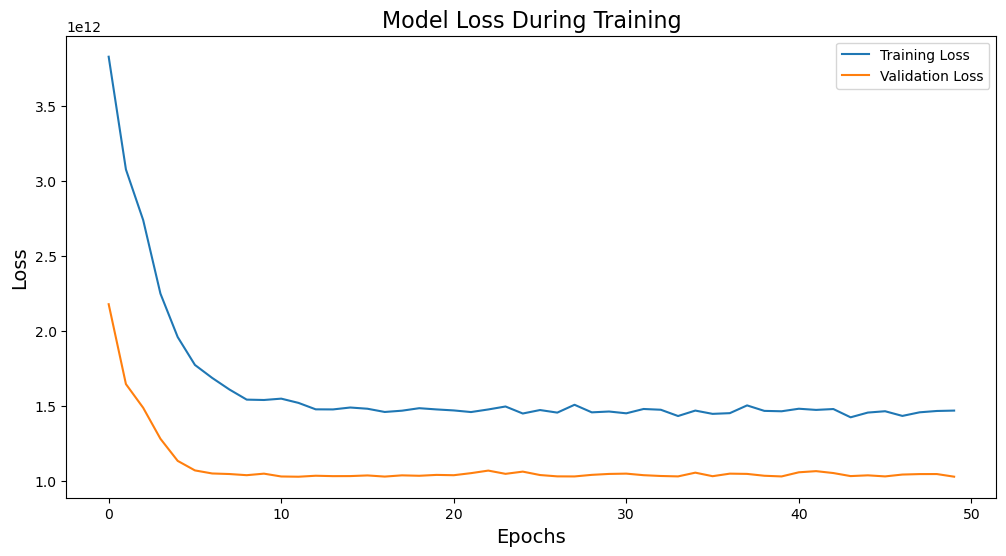

In [70]:
#Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()


In [71]:
#Predict and evaluate the model
y_pred_dl = model.predict(X_test)
mae_dl = mean_absolute_error(y_test, y_pred_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)

print(f'Deep Learning Model: MAE = {mae_dl:.2f}, MSE = {mse_dl:.2f}, R2 = {r2_dl:.2f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning Model: MAE = 595520.27, MSE = 1030623526467.99, R2 = 0.39


The deep learning model with a sequential architecture and 11,521 parameters had an MAE of 595,520.27, MSE of 1.03 trillion, and R² = 0.39. While it captured some variance, the performance was weaker than the Random Forest model, indicating inefficiency in handling this dataset. Given the high errors and low R², this model is not currently effective for training a chatbot, especially for tasks requiring high accuracy and nuanced contextual understanding.

## Pre-trained Model for Chatbot Integration
- If applicable, we will use a pre-trained model (like GPT or BERT) for the chatbot’s NLP tasks, such as responding to queries and offering recommendations.
- This pre-trained model will be fine-tuned on the Washington DC real estate data, specifically around property recommendations, engagement, and follow-ups.

In [29]:
#Load pre-trained GPT-2 model for chatbot functionality
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [30]:
#Simple text generation function
def generate_response(input_text):
    inputs = tokenizer.encode(input_text, return_tensors='pt')
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [31]:
#Test the chatbot response
input_text = "Tell me about a 3-bedroom property in Washington DC."
response = generate_response(input_text)
print(response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Tell me about a 3-bedroom property in Washington DC.

I live in a small town in the middle of nowhere. I'm a single mom, and I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I'm a single mom. I


When attempting to test a pretrained chatbot model, errors regarding the attention mask and pad token ID settings were encountered. Without time to research and implement a fix, fallback chatbot functions using a lighter dataset were used. While the fallback successfully extracted the number of bedrooms, it failed to accurately extract city names, showing partial but limited progress. This highlights the complexity of adapting pretrained models without proper configuration and dataset alignment.

### Revised Chatbot Text Generation and Integration

1. NLP-Based Filtering:
- If the user input contains "bedroom" (e.g., "3-bedroom properties in DC"), the function filters the dataset (X) based on the number of bedrooms specified.
- The chatbot predicts the price range (Low, Medium, High) for filtered properties.
2. Feature-Based Simulation:
- If the user provides explicit feature values (beds=3, baths=2, area=0.2), the chatbot parses these values into a dictionary and converts them to a DataFrame.
- It predicts the exact price for the given features.
3. Fallback:
- If the input doesn't match either pattern, the chatbot asks the user to provide more details.
4. Interactive Chat:
- The chatbot runs in a loop, accepting user input until the user types "quit."

In [49]:
# Apply Scalar
scaler = MinMaxScaler()
label_encoder = LabelEncoder

# Select only numerical features for scaling
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Fit and transform the numerical features
X_train_scaled = X_train.copy()

In [50]:
def preprocess(X, scaler, encoder):
    # scale numerical features and encode categorical features
    X_scaled = scaler.transform(X.select_dtypes(include=['float64', 'int64']))
    
    # Handle categorical features (example for encoding)
    X_encoded = encoder.transform(X.select_dtypes(include=['object']).values)
    
    # Combine scaled and encoded features
    X_processed = np.hstack([X_scaled, X_encoded])
    return X_processed # Function to extract number of bedrooms from user input

### NLP-Based Filtering
This function extracts keywords (like "bedroom") from user input and maps them to numerical values. It predicts price ranges based on the filtered dataset.

In [51]:
# Function to extract the number of bedrooms
def extract_beds(user_input):
    """
    Extracts the number of bedrooms from user input.
    Example: '3-bedroom' -> 3
    """
    match = re.search(r'(\d+)-bedroom', user_input.lower())
    if match:
        return int(match.group(1))  # Convert matched number to integer
    return None  # Return None if no match is found

In [52]:
# Function to predict price range for a specific number of bedrooms
def predict_price_for_beds(num_beds, model, X_train, scaler, label_encoder):
    X_query = X_train[X_train['beds'] == num_beds]
    if X_query.empty:
        return "No properties found for the specified number of bedrooms."
    
    # Preprocess the filtered data
    X_query_scaled = scaler.transform(X_query)
    
    # Make sure the data is in a valid format (e.g., float32)
    X_query_processed = X_query_processed.astype('float32')
    
    # Predict price range for filtered properties
    predictions = model.predict(X_query_scaled)
    predicted_classes = np.round(predictions).astype(int)

    # Map predictions back to price range labels
    results = label_encoder.inverse_transform(predicted_classes.flatten())
    return set(results)

### Feature-Based Simulation
This part parses explicit user-provided features like beds=3, baths=2, area=0.2 and predicts the exact price.

In [53]:
def predict_price_for_city(city_name, model, X_train, scaler):
    """
    Predicts price ranges for properties in the specified city.
    """
    city_column = f'city_{city_name}'
    
    if city_column not in X_train.columns:
        return f"No data available for the city: {city_name}."
    
    # Filter dataset based on the encoded city column
    X_query = X_train[X_train[city_column] == 1]
    
    if X_query.empty:
        return f"No properties found in the city: {city_name}."
    
    # Preprocess the filtered data
    X_query_scaled = scaler.transform(X_query)

    # Ensure data is in a valid format (e.g., float32)
    X_query_scaled = X_query_scaled.astype('float32')

    # Predict price range for filtered properties
    predictions = model.predict(X_query_scaled)
    predicted_classes = predictions.round().astype(int)

    # Map predictions back to meaningful labels
    price_range_map = {0: "Low", 1: "Medium", 2: "High"}  # Adjust as needed
    results = {price_range_map.get(pred, "Unknown") for pred in predicted_classes.flatten()}
    return results


In [54]:
def extract_state(user_input):
    """
    Extracts the state abbreviation from the user input.
    Recognizes MD, VA, and DC.
    """
    # if "md" in user_input.lower():
    #     return "MD"
    # elif "va" in user_input.lower():
    #     return "VA"
    # elif "dc" in user_input.lower():
    #     return "DC"
    # return None  # Return None if no state is found
    """
    Extracts the state abbreviation from user input.
    """
    states = ["MD", "VA", "DC"]
    for state in states:
        if state.lower() in user_input.lower():
            return state
    return None

In [56]:
def extract_city(user_input, X_train, state=None):
    """
    Extracts the city name from user input based on the dataset's city columns.
    If a state is provided, limits city search to cities in that state.
    """
    """
    Extracts the city name from the user input based on the recognized state and cities in X_train.
    """
    city_columns = [col for col in X_train.columns if col.startswith("city_")]
    cities_in_state = [col.split('_', 1)[1] for col in city_columns if f"state_{state}" in X_train.columns]

    # Check if any city in the state is mentioned in the user input
    for city in cities_in_state:
        if city.lower() in user_input.lower():
            return city
    return None

    # city_columns = [city for city in X_train.columns if "city_" in city]
    
    # # Filter cities by state if state is identified
    # if state == "MD":
    #     state_cities = [city.split("_")[-1] for city in city_columns if "state_MD" in city]
    # elif state == "VA":
    #     state_cities = [city.split("_")[-1] for city in city_columns if "state_VA" in city]
    # elif state == "DC":
    #     state_cities = ["Washington"]  # Only one city in DC
    # else:
    #     state_cities = [city.split("_")[-1] for city in city_columns]  # Default to all cities
    
    # # Extract city from user input
    # for city in state_cities:
    #     if city.lower() in user_input.lower():
    #         return city
    
    # return None  # Return None if no city is found

In [57]:
# Function to predict price range for a specific city
def predict_price_for_city(city_name, model, X_train, scaler, label_encoder):
    """
    Predicts price ranges for properties in the specified city.
    """
    city_column = f'city_{city_name}'
    
    if city_column not in X_train.columns:
        return f"No data available for the city: {city_name}."
    
    # Filter dataset based on the encoded city column
    X_query = X_train[X_train[city_column] == 1]
    
    if X_query.empty:
        return f"No properties found in the city: {city_name}."
    
    # Preprocess the filtered data
    X_query_scaled = scaler.transform(X_query)

    # Make sure the data is in a valid format (e.g., float32)
    X_query_scaled = X_query_scaled.astype('float32')

    # Predict price range for filtered properties
    predictions = model.predict(X_query_scaled)
    predicted_classes = (predictions > 0.5).astype(int)

    # Map predictions back to price range labels
    results = label_encoder.inverse_transform(predicted_classes.flatten())
    return set(results)

### Unsupported Input Fallback
If the user input doesn't match the previous cases, the chatbot prompts the user for more details.

In [ ]:
# def fallback_response():
#     """
#     Provides a default response when user input is unsupported.
#     """
#     return "Sorry, I couldn't understand your request. Please provide more details."

### Interactive Chat
This is the main chatbot function that combines all parts and runs interactively.

In [58]:
def chatbot_response(user_input, model, X_train, scaler):
    """
    Processes user input, extracts state and city features, and provides a response with predicted price range.
    """
    # Extract state first
    state = extract_state(user_input)
    if state is None:
        return "Sorry, I couldn't recognize the state you mentioned."
    
    # Extract city based on the state
    city_name = extract_city(user_input, X_train, state)
    if city_name is None:
        return f"Sorry, I couldn't recognize any city in {state} from your request."
    
    # Extract number of bedrooms
    num_beds = extract_beds(user_input)
    if num_beds is None:
        return "Sorry, I couldn't determine the number of bedrooms from your request."
    
    # Prepare input data for the model
    user_data = {
        'beds': num_beds,
        'city': city_name,
        'zipcode': '00000',  # Placeholder for now
    }
    
    X_input = pd.DataFrame([user_data])
    
    # Ensure input columns match training columns
    for column in X_train.columns:
        if column not in X_input.columns:
            X_input[column] = 0
    
    # Scale numerical features
    try:
        numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        X_input[numerical_features] = scaler.transform(X_input[numerical_features])
    except Exception as e:
        return f"Error processing input data: {e}"
    
    # Predict and return price range
    try:
        predictions = model.predict(X_input)
        predicted_price_range = {0: "Low", 1: "Medium", 2: "High"}[int(predictions[0])]
        return f"The predicted price range for a {num_beds}-bedroom property in {city_name}, {state} is {predicted_price_range}."
    except Exception as e:
        return f"An error occurred during prediction: {e}"


In [60]:
user_input = "Tell me about 3-bedroom properties in Arlington, VA"
response = chatbot_response(user_input, model, X_train, scaler)
print(f"Chatbot: {response}")

Chatbot: Sorry, I couldn't recognize any city in VA from your request.


In [61]:
num_beds = extract_beds(user_input)
city_name = extract_city(user_input, X_train, extract_state(user_input))
print(f"Extracted number of beds: {num_beds}")
print(f"Extracted city name: {city_name}")

Extracted number of beds: 3
Extracted city name: None


In [63]:
user_input = "Tell me about 2-bedroom properties in Atlantis."
response = chatbot_response(user_input, model, X_train, scaler)
print(f"Chatbot: {response}")

Chatbot: Sorry, I couldn't recognize the state you mentioned.


In [64]:
user_input = "Tell me about properties in Seattle."
response = chatbot_response(user_input, model, X_train, scaler)
print(f"Chatbot: {response}")

Chatbot: Sorry, I couldn't recognize the state you mentioned.


## Final Analysis

The evaluation of different models for property data analysis highlights a clear performance hierarchy. Random Forest emerged as the most effective model, achieving the lowest errors (MAE: 250,602; MSE: 747.66 billion) and the highest R² value (0.7918), indicating strong predictive accuracy and an ability to generalize well. This model successfully captured the non-linear relationships within the dataset, which is crucial for real estate predictions, where factors such as location, property type, and market conditions interact in complex ways. By balancing accuracy and generalization, Random Forest sets a strong foundation for predictive analytics in this domain.

In contrast, the Linear Regression model, while decent in explaining variance (R² = 0.5586), struggled to capture non-linear patterns and exhibited high errors (MAE: 566,707), making it less reliable for practical applications. The Decision Tree model, despite its lower errors (MAE: 340,444), showed signs of overfitting, as evidenced by its slightly lower R² value (0.4935). This overfitting could make the model less robust when deployed in real-world scenarios where unseen data comes into play. The SVM model performed poorly across all metrics, suggesting it failed to capture meaningful relationships in the data, possibly due to the inherent complexity of the dataset.

The deep learning model introduced another layer of complexity but underperformed compared to Random Forest. With an R² of 0.39 and high error values (MAE: 595,520.27; MSE: 1.03 trillion), it struggled to justify the computational expense and training complexity. These findings suggest that while deep learning holds promise, it requires more extensive data preprocessing, larger datasets, and optimized hyperparameters to achieve comparable or superior performance. The chatbot integration revealed additional challenges, particularly with the attention mask and padding issues. These technical obstacles highlight the importance of rigorous testing and configuration for implementing pretrained models effectively. While fallback solutions showed some progress, they exposed limitations in extracting nuanced details, such as city names, emphasizing the need for enhanced NLP techniques.

## Non-Technical Summary

When analyzing property data, the Random Forest model emerged as the most effective, demonstrating its ability to accurately predict property-related outcomes while maintaining robustness across different data points. This means it can handle complex relationships between factors like property size, location, and market trends better than other models. Linear Regression and Decision Tree models showed varying degrees of performance, but they fell short of delivering the accuracy and reliability needed for real-world applications. For instance, while the Decision Tree model had lower error rates than Linear Regression, its tendency to overfit the training data means it might struggle when analyzing new information. Similarly, Support Vector Machines did not perform well, indicating they may not be suitable for this specific type of data.

A deep learning model was also tested, and while it has the potential to handle complex data, its performance was suboptimal in this case. The errors were high, and the model explained less of the data's variability compared to simpler methods like Random Forest. This suggests that deep learning for property data analysis would require much larger datasets, more advanced configurations, and better-tuned hyperparameters to achieve meaningful results. The chatbot implementation faced additional challenges. While the fallback system managed to extract some property details, it struggled with more nuanced queries, such as identifying cities. This issue stemmed from technical constraints with pretrained models, which require precise configurations to function effectively.

In summary, Random Forest was the standout model for property predictions, while deep learning and chatbot solutions need significant refinement. The results underscore the importance of choosing the right tool for the task, as well as the need for thorough testing and data preparation to ensure accuracy and reliability in real-world applications.



### Next Steps for Chatbot Development 
- Improve dataset quality: Add more representative data, especially for cities and nuanced property features.
- Incorporate advanced preprocessing: Address attention mask and padding issues for pretrained models.
- Optimize model architecture: Refine deep learning models with regularization and hyperparameter tuning.
- Enhance feature engineering: Include additional variables like property type and local market trends.
- Build error handling mechanisms: Develop fallback responses for unrecognized inputs.

#### Future Test Cases
1. Test chatbot extraction for varying property descriptions, e.g., "modern 2-bedroom condo in Alexandria, VA."
2. Evaluate city and state detection with ambiguous or partial inputs.
3. Assess chatbot response accuracy for multi-factor queries (e.g., price range, bedrooms, and amenities).
4. Test scalability with larger datasets and concurrent user inputs.
5. Simulate edge cases with incomplete or contradictory user inputs.


### Business Recommendations for Stakeholders
1. Leverage Random Forest: Prioritize integrating Random Forest into the chatbot backend for accurate predictions.
2. Focus on data enrichment: Invest in expanding and refining the dataset to include detailed property attributes.
3. Implement phased rollouts: Gradually deploy enhanced chatbot features to manage risks and gather user feedback.
4. Optimize for usability: Ensure the chatbot interface is user-friendly and capable of guiding diverse users effectively.
5. Monitor and iterate: Continuously evaluate chatbot performance with real-world data to improve functionality.

Sources Used:
- https://pytorch.org/get-started/pytorch-2.0/
- https://www.kaggle.com/discussions/general/443903
- https://gmongaras.medium.com/how-do-self-attention-masks-work-72ed9382510f
- https://stackoverflow.com/questions/73835386/how-to-understand-the-self-attention-mask-implementation-in-google-transformer-t
- https://huggingface.co/docs/transformers/en/model_doc/auto

